In [1]:
import os
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import scienceplots
plt.style.use(['science', 'no-latex'])
plt.rc('text', usetex=True)

from src.plots import set_size

df_dict = {}
LOGDIR = 'logs_preprocessor'

# key_extractor = lambda x: x.split('_')[1:]

for subfolder in os.listdir(LOGDIR):
    subfolder_path = os.path.join(LOGDIR, subfolder)
    csv_file_path = os.path.join(subfolder_path, 'version_0', 'metrics.csv')
    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path)
        encoder = ' '.join(subfolder.split('_')[:-1]).title()
        df_dict[encoder] = df

In [2]:
df_dict['Embedded'].head()

,train_loss,epoch,step,val_loss,val_acc,val_f1,val_auc,val_tpr,train_acc,train_f1,train_auc,train_tpr
0,0.683580,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.676178,0,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0,25,0.6676,0.593558,0.328229,0.88048,0.0,NaN,NaN,NaN,NaN
3,0.667257,0,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.653829,0,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def extract_metric_values(df_dict, metric_name, operation='last'):
    """
    Extracts specified metric values (either last or max) from nested DataFrames in df_dict.
    
    Parameters:
        df_dict (defaultdict(dict)): Nested dictionary of DataFrames keyed by tokenizer and vocab_size.
        metric_name (str): The name of the metric to extract.
        operation (str): The operation to perform ('last' or 'max').
        
    Returns:
        DataFrame: DataFrame containing the extracted metric values, indexed by vocab_size and columns by tokenizer.
    """
    # Initialize an empty dictionary to temporarily store the extracted values
    extracted_values_temp = {}
    
    # Loop through the nested DataFrames
    for encoder, df in df_dict.items():
        if metric_name in df.columns:
            if operation == 'last':
                # Extract the last value of the specified metric
                last_value = df[metric_name].dropna().iloc[-1]
                extracted_values_temp[encoder] = last_value
                
            elif operation == 'max':
                # Extract the maximum value of the specified metric
                max_value = df[metric_name].dropna().max()
                extracted_values_temp[encoder] = max_value
            else:
                print(f"Invalid operation '{operation}' specified. Skipping {encoder}.")
        else:
            print(f"Metric '{metric_name}' not found in DataFrame for {encoder}. Skipping.")
                
    # Convert the nested dictionary to a DataFrame, using 'metric_name' as value for index
    extracted_values_df = pd.DataFrame.from_dict(extracted_values_temp, orient='index', columns=[metric_name]).transpose()

    # sort index by vocab_size
    extracted_values_df.sort_index(inplace=True)

    return extracted_values_df


In [4]:
df1 = extract_metric_values(df_dict, 'val_f1', operation='last')
df2 = extract_metric_values(df_dict, 'val_tpr', operation='last')
df = pd.concat([df1, df2], axis=0)
df

,Embedded,Embedded Positional,Minhash,Onehot,Tfidf
val_f1,0.936148,0.954142,0.994961,0.998168,0.996393
val_tpr,0.839594,0.905537,0.940897,0.995570,0.974655


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Embedded'),
  Text(1, 0, 'Embedded Positional'),
  Text(2, 0, 'Minhash'),
  Text(3, 0, 'Onehot'),
  Text(4, 0, 'Tfidf')])

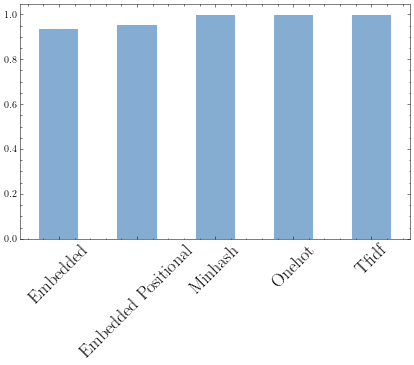

In [5]:
fig, ax = plt.subplots(figsize=set_size())

metric = 'val_f1'
df.T[metric].plot.bar(ax=ax, color='C0', alpha=0.5, width=0.5)
# rotate xticklabels and set fontsize as 18
plt.xticks(rotation=45, fontsize=18)

# # save figure to img/ as pdf
# fig.savefig('img/tokenizer_vocabsize_f1.pdf', bbox_inches='tight', dpi=300)

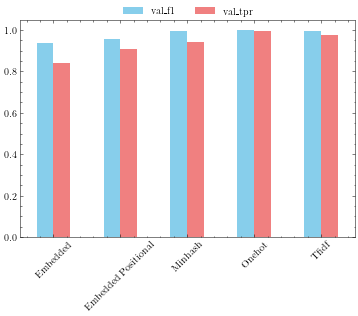

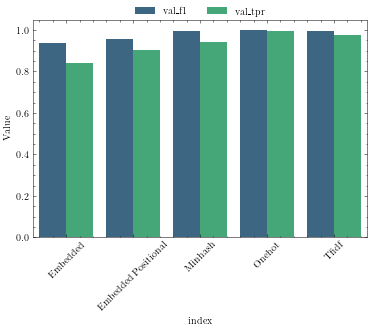

In [6]:
# Using matplotlib
df.T.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)
plt.show()
# legend above in 2 cols

# Using seaborn
df_melted = df.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
sns.barplot(data=df_melted, x='index', y='Value', hue='Metric', palette='viridis')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)
plt.show()


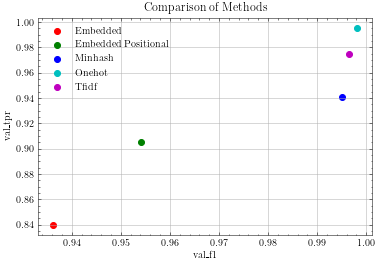

In [7]:
for method, color in zip(df.columns, ['r', 'g', 'b', 'c', 'm']):
    plt.scatter(df[method]['val_f1'], df[method]['val_tpr'], label=method, color=color)

plt.xlabel('val_f1')
plt.ylabel('val_tpr')
plt.legend()
plt.title('Comparison of Methods')
plt.grid(True)
plt.show()

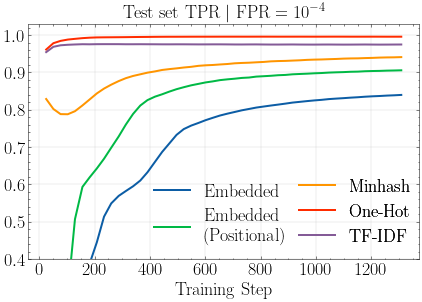

In [11]:
# Load data
fig, ax = plt.subplots(figsize=set_size())

metric = 'val_tpr'
for subfolder in os.listdir('logs_preprocessor'):
    encoder = ' '.join(subfolder.split('_')[:-1]).title()
    if " " in encoder:
        encoder = encoder.replace(" ", "\n")
    if not subfolder.endswith("csv"):
        continue
    data = pd.read_csv(rf'logs_preprocessor\{subfolder}\version_0\metrics.csv')
    ldf = data[['step', metric]]
    # filter out indexes where val_f1 notna
    ldf = ldf[ldf[metric].notna()]
    
    ldf.plot(x='step', y=metric, kind='line', ax=ax, label=encoder, linewidth=2, fontsize=18)
    # plot with thick lines, as above but using ax.plot
    
# custom legend, first two elements go first, then last three
handles, labels = ax.get_legend_handles_labels()
l1 = plt.legend(
    handles[:2],
    ['Embedded', 'Embedded\n(Positional)'],
    fontsize=18,
    ncol=1,
    loc='lower left',
    bbox_to_anchor=(0.28, -0.01)
)
l2 = plt.legend(
    handles[2:],
    ['Minhash', 'One-Hot', 'TF-IDF'],
    fontsize=18,
    ncol=1,
    loc='lower left',
    bbox_to_anchor=(0.65, -0.01)
)
ax.add_artist(l1)
ax.add_artist(l2)

# increase font of xlabel
ax.set_xlabel('Training Step', fontsize=18)
ax.set_title(r'Test set $\text{TPR}~|~\text{FPR} = 10^{-4}$', fontsize=18)

ax.set_ylim(0.4, 1.03)
ax.grid(linewidth=0.2)

# save figure to img/ as pdf
fig.savefig('img/encoder_tpr.pdf', bbox_inches='tight', dpi=300)

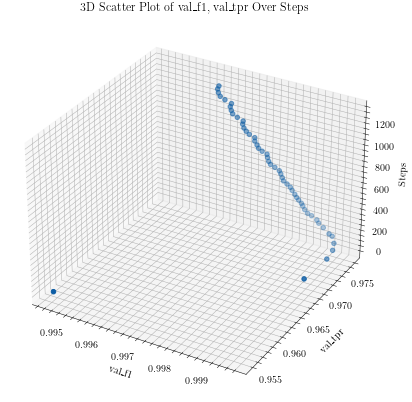

In [9]:
import matplotlib.pyplot as plt

# 3D Scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['val_f1'], data['val_tpr'], data['step'], depthshade=True)
ax.set_title('3D Scatter Plot of val_f1, val_tpr Over Steps')
ax.set_xlabel('val_f1')
ax.set_ylabel('val_tpr')
ax.set_zlabel('Steps')

plt.show()


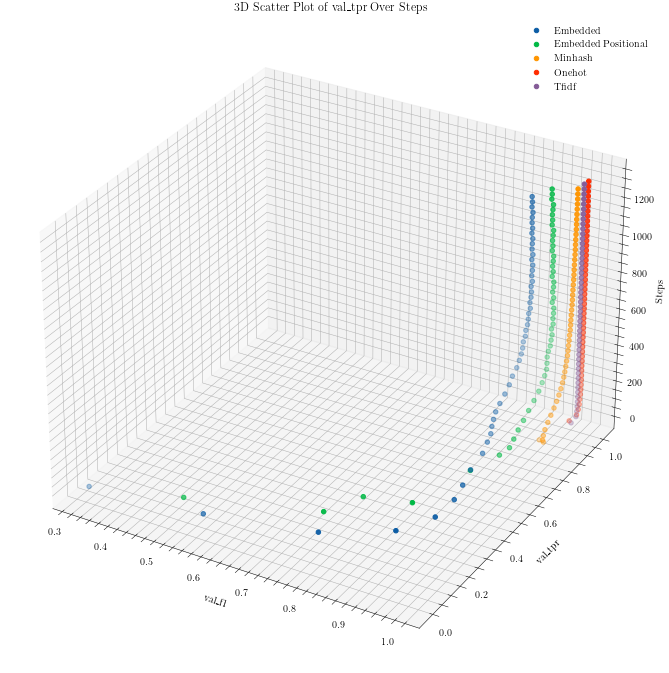

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111, projection='3d')

def encoder_extractor(s):
    return ' '.join(s.split('_')[:-1]).title()

for subfolder in os.listdir('logs_preprocessor'):
    encoder = encoder_extractor(subfolder)
    if not subfolder.endswith("csv"):
        continue
    
    data_path = rf'logs_preprocessor\{subfolder}\version_0\metrics.csv'
    data = pd.read_csv(data_path)
    
    # Ensure 'step' and the specified metric columns are not NaN
    data = data[data['step'].notna() & data[metric].notna()]
    
    ax.scatter(data['val_f1'], data['val_tpr'], data['step'], depthshade=True, label=encoder)

ax.set_title(f'3D Scatter Plot of {metric} Over Steps')
ax.set_zlabel('Steps')
ax.set_xlabel('val_f1')
ax.set_ylabel('val_tpr')
ax.legend()
plt.show()
